<a href="https://colab.research.google.com/github/kwisnie2/MEB_PHYSIC9710/blob/main/PHYSICS_9710R_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
/content/drive/MyDrive/GLM


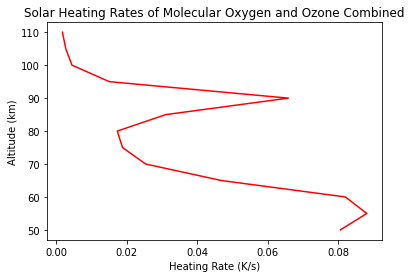

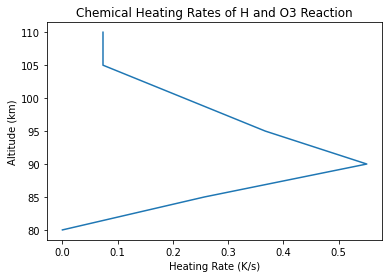

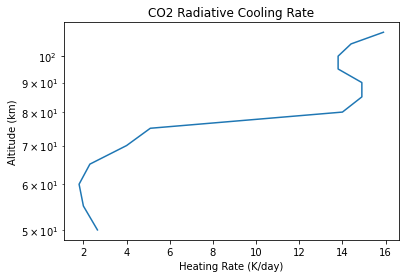

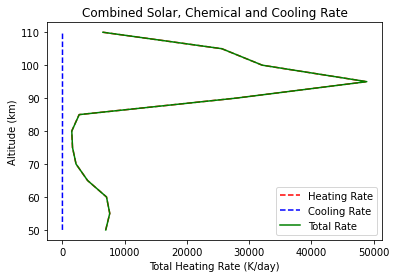

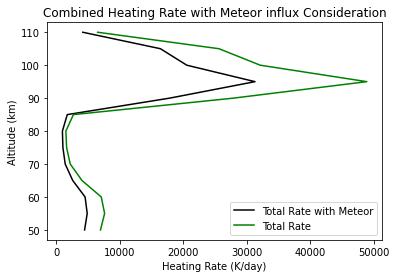

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GLM/

import numpy as np 
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate
from google.colab import files
import math as mt


#################################################
#Known Constants that don't change with altitude#
#################################################


c = 3.0e10                     #Speed of Light (cm/s) 
h = 6.62607004e-27             #Plancks constant (cm^2g/s)
w_O3 = 2.55e-7                 #Hartley Band for Ozone (cm)
w_O2 = 7.62e-7                 #Atmospheric Band for O2  (cm)

nu_O2 = c/w_O2                 #Frequency value (Hz, s^-1)
nu_O3 = c/w_O3                 #Frequency value (Hz, s^-1)

D_O2 = (498*1000)/6.022e23     #Bond Dissociation Energy (J), from kJ/mol to J conversion
D_O3 = (364*1000)/6.022e23     #Bond Dissociation Energy (J), from kJ/mol to J conversion, note Ozone has weaker O bonds

e_O2 = 0.9                     #Heating Efficinecy (unitless), [2] average from 
e_O3 = 0.85                    #Heating Efficinecy (unitless), [2] average from 
Cp_O2 = 0.92                   #J/g K heat capacity 
Cp_O3 = 2.231                  #J/g K heat capacity 

k_O2= 4.8e-13                  #Quenching Rate for O2 (cm^3/s)
k_O3= 4.8e-13                  #Quenching Rate for O3 (cm^3/s) 

A = 1.47e-4                    #Einstein's Coefficient for Spontaneous Emission (s^-1) (from [1])


################################
#Values that depend on altitude#
################################


alt = [50,55,60,65,70,75,80,85,90,95,100,105,110]
                               #altitude (km) 

V_O2 = [1e7, 9.0e6, 7.5e6, 3.5e6, 2e6, 1.4e6 , 8e5, 5e5, 8e5, 1.5e5, 2.5e4, 9.0e3, 3e3] 
                               #Volume Emission for O2 (photon cm^-3/s)
                              
airglow_O2 = [0.4508e11, 0.3239e11, 0.2160e11, 0.1189e11, 0.6442e10, 0.2789e10, 0.1921e10, 0.2546e10, 0.8932e09, 0.2853e09, 0.1101e09, 0.5808e08, 0.2508e08] 
                               #Denisty of O2 airglow (molecules/cm^3)

                           
#####################################################################################
#Calculate Using Ideal Gas Law:                                                     #
#rho=PM/RT where P is pressure, M is molar mass, R is gas constant, T is temperature#
#####################################################################################


P_hPa = [0.564, 0.317, 0.178, 0.752e-01, 0.423e-01, 0.179e-01, 0.753e-02, 0.318e-02, 0.101e-02, 0.424e-03, 0.179e-03, 0.101e-03, 0.566e-04]

P = [x*0.0009869233 for x in P_hPa]                                    #now pressure is in atm
M_O2 = 32                                                              #Molar Mass (g/mol)
M_O3 = 48                                                              #Molar Mass (g/mol)
T = [266, 252, 236, 219, 211, 206, 194, 184, 184, 191, 203, 219, 261]  #Temperature (K)
R = 82.057                                                             #Ideal Gas Constant (cm^3 atm/ K mol)
rho_O2 = [M_O2*p/(R*t) for p,t in zip(P,T)]                            #Denisty of O2 (g/cm^3)
rho_O3 = [M_O3*p/(R*t) for p,t in zip(P,T)]                            #Denisty of O3 (g/cm^3)


########################################################                          
#Final Heating Rate Calculation                        #
#Note: factor of 1e-7 is conversion from ergs to joules#
######################################################## 

h_rate_O2 = [((e_O2/(Cp_O2*x))*(h*nu_O2*1e-7 - D_O2)*(1+ (k_O2*y/A))*v) for x,y,v in zip(rho_O2,airglow_O2,V_O2)]
h_rate_O3 = [((e_O3/(Cp_O3*x))*(h*nu_O3*1e-7 - D_O3)*(1+ (k_O3*y/A))*v) for x,y,v in zip(rho_O3,airglow_O2,V_O2)]
heat_rate = [x+y for x,y in zip(h_rate_O2,h_rate_O3)]
plt.plot(heat_rate,alt, '-r')
plt.xlabel('Heating Rate (K/s)')
plt.ylabel('Altitude (km)')
plt.title('Solar Heating Rates of Molecular Oxygen and Ozone Combined')
plt.savefig('Solar_Heating.png')
plt.show()


######################################
#Chemical Heating from H +O3 reaction#
######################################

alt2 = [110, 105, 100, 95, 90, 85, 80]                                       #Altitude (km)
H_con = [7.8e-11, 1.56e-10, 3.9e-10, 6.24e-10, 2.34e-9, 5.46e-9, 1.17e-8]    #Hydrogen Concentration (cm^-3)
O3_con = [1e-6, 1e-6, 3e-6, 5e-6, 7.5e-6, 3.5e-6, 0]                         #Ozone Concentration (cm^-3)
M = [4.211e12, 8.422e12, 2.105e13, 3.369e13, 1.263e14, 2.948e14, 6.317e14]   #Number Density (atoms/cm^3)
k = 0.6                                                                      #rate of reaction coefficient (s^-1)
k_b = 3.3e-27                                                                #boltzmann constant (J/K)
delta_H = 76.3                                                               #Enthalpy of Reaction (kJ/mol)

chem_rate = [(2/7)*k*(1/k_b)*(1/m)*c*o*delta_H for m,c,o in zip(M,H_con,O3_con)]
plt.plot(chem_rate,alt2)
plt.xlabel('Heating Rate (K/s)')
plt.ylabel('Altitude (km)')
plt.title('Chemical Heating Rates of H and O3 Reaction')
plt.savefig('Chemical_Heating.png')
plt.show()



########################
#Radiative Cooling Rate#
########################
# these values were taken from an existing plot.

P = [7.5e-2, 4.5e-2, 2.2e-2, 1e-2, 6e-3, 5e-3, 1.7e-3, 1.5e-3, 1e-3, 6.5e-4, 5e-4, 4e-4, 3.1e-4]
                            #Pressure (hPa)
cool_rate=[2.65, 2, 1.8, 2.3, 4, 5.1,  14, 14.9, 14.9, 13.8, 13.8, 14.4, 15.9]
                            #Cooling Rate (K/day)

plt.plot(cool_rate, alt)
plt.yscale("log")
plt.xlabel('Heating Rate (K/day)')
plt.ylabel('Altitude (km)')
plt.title('CO2 Radiative Cooling Rate')
plt.savefig('Radtiative_Cooling.png')
plt.show()

#########################
#Total Temperature Rates#
#########################

Heating_tot = [0.08055597386851276, 0.0880344493479873, 0.08197703801555906, 0.04678337567205016, 0.025335773372979854, 0.018767605938270957, 0.017275738716235868, 0.031054119139872216, 0.0657869123554195+0.25693721475268283, 0.015042539033158431+0.5507665730943642, 0.004442347247535849+0.36706872824415115, 0.0026756610893061573+0.07341810409965241+0.2203066292377456, 0.0017249519822416259+0.07341810409965241]
heating_tot = [x*86400 for x in Heating_tot]
total_rate = [x+y for x,y in zip(heating_tot, cool_rate)]

plt.plot(heating_tot, alt, '--r', label='Heating Rate')
plt.plot(cool_rate, alt, '--b', label='Cooling Rate')
plt.plot(total_rate, alt, '-g', label='Total Rate')
plt.xlabel('Total Heating Rate (K/day)')
plt.ylabel('Altitude (km)')
plt.title('Combined Solar, Chemical and Cooling Rate')
plt.legend(loc="lower right")
plt.savefig('Total_Heating.png')
plt.show()


######################
#Add Meteor Influence#
######################


meteor = 0.64                                    #Calculated Heating from Meteors (K/day)
heating = [x*86400 for x in Heating_tot]         #Covering heating to K/day from K/s, cooling is already done
cool_rate=[2.65, 2, 1.8, 2.3, 4, 5.1,  14, 14.9, 14.9, 13.8, 13.8, 14.4, 15.9]
                                                 #Copied cooling rate
rate_meteor = [(x+y)*meteor for x,y in zip(heating,cool_rate)]

plt.plot(rate_meteor, alt, '-k', label='Total Rate with Meteor')
plt.plot(total_rate, alt, '-g', label='Total Rate')
plt.xlabel('Heating Rate (K/day)')
plt.ylabel('Altitude (km)')
plt.title('Combined Heating Rate with Meteor influx Consideration')
plt.legend(loc="lower right")
plt.savefig('Total_Heating_Meteor.png')
plt.show()


#########
#Sources#
#########


#[1] The Einstein Coefficient for spontaneous emission of the O2(a¹Δg) state
#[2] A detailed evaluation of heating processes in the middle atmosphere

